In [39]:
pip install git+https://github.com/shashikg/google_colab_plugins

  Cloning https://github.com/shashikg/google_colab_plugins to /tmp/pip-req-build-vi6v0umr
  Running command git clone -q https://github.com/shashikg/google_colab_plugins /tmp/pip-req-build-vi6v0umr
  Created wheel for google-colab-plugins: filename=google_colab_plugins-0.1-cp36-none-any.whl size=3075 sha256=b49429d839d9897640462faa306cae00e760f0a7f577ec618c7cf237cdb08c66
  Stored in directory: /tmp/pip-ephem-wheel-cache-h6_75djs/wheels/0d/7a/c0/f08e26849983b61cab0600b42d2547a3a963f611f738877eff
Successfully built google-colab-plugins


In [40]:
!pip install scikit-video

In [41]:
!pip install --upgrade mxnet gluoncv

Requirement already up-to-date: mxnet in /usr/local/lib/python3.6/dist-packages (1.7.0.post1)
Requirement already up-to-date: gluoncv in /usr/local/lib/python3.6/dist-packages (0.8.0)


In [42]:
!git clone https://github.com/pragyanpandey/Undergraduate-Project.git

fatal: destination path 'Undergraduate-Project' already exists and is not an empty directory.


In [43]:
!unzip /content/Undergraduate-Project/Test_video_1.zip -d my_data

Archive:  /content/Undergraduate-Project/Test_video_1.zip
replace my_data/stock-footage-excited-happy-young-parents-run-push-cardboard-boxes-with-little-cute-children-daughters-ride.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: my_data/stock-footage-excited-happy-young-parents-run-push-cardboard-boxes-with-little-cute-children-daughters-ride.mp4  


In [44]:
%matplotlib inline

In [45]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from skvideo.io import FFmpegWriter as VideoWriter
from google_colab_plugins import playVideo
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt

In [46]:
def yolo():
  net = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)
  x, img = data.transforms.presets.yolo.load_test('first_frame.jpg', short=512)
  class_IDs, scores, bounding_boxs = net(x)
  '''
  print('Shape of pre-processed image:', x.shape)
  print(class_IDs[0])
  print((scores[0]))
  print(bounding_boxs[0])
  print(net.classes)
  print(class_IDs.shape)
  print(scores.shape)
  print(bounding_boxs.shape)
  
  ax = utils.viz.plot_bbox(img, bounding_boxs[0], scores[0],
                         class_IDs[0], class_names=net.classes)
  plt.show()
  '''
  decided_class = ((scores.flatten())[0]>0.6)
  decided_indices = np.where(decided_class == 1)[0]
  decided_boxes = bounding_boxs[0][decided_indices]
  '''
  print(decided_class)
  print(decided_indices)
  print(decided_boxes)
  '''
  return decided_boxes.asnumpy(), x.shape[2], x.shape[3]

In [47]:
class Mean_Shift_Tracker(object):
  def __init__(self):
    self.x = None
    self.y = None
    self.width = None
    self.height = None
    self.first_frame = None
    self.roi_hist = None
    self.term_criteria = None

  def initialize(self, x_, y_, width_, height_, first_frame_):
    self.x = x_
    self.y = y_
    self.width = width_
    self.height = height_
    self.first_frame = first_frame_    

  def distribution_learner(self):
    roi = self.first_frame[self.y: self.y + self.height, self.x: self.x + self.width]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    self.roi_hist = cv2.calcHist([hsv_roi], [0], None, [180], [0, 180])
    self.roi_hist = cv2.normalize(self.roi_hist, self.roi_hist, 0, 255, cv2.NORM_MINMAX)

    self.term_criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

  def frame_marker_tracker(self, frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.calcBackProject([hsv], [0], self.roi_hist, [0, 180], 1)

    _, track_window = cv2.meanShift(mask, (self.x, self.y, self.width, self.height), self.term_criteria)
    self.x, self.y, w, h = track_window
    cv2.rectangle(frame, (self.x, self.y), (self.x + w, self.y + h), (0, 255, 0), 2)
    return frame


In [48]:
video = cv2.VideoCapture('/content/my_data/stock-footage-excited-happy-young-parents-run-push-cardboard-boxes-with-little-cute-children-daughters-ride.mp4')
#video = cv2.VideoCapture('stock-footage-playful-crazy-young-daddy-and-cute-kid-son-having-fun-dancing-together-in-living-room-interior.mp4')
#video = cv2.VideoCapture("mouthwash.avi")
fps = video.get(cv2.CAP_PROP_FPS)
print(fps)
out = VideoWriter("mouthwash_follower.mp4", inputdict={'-r': str(fps)}, outputdict={'-r': str(fps)})

if not video.isOpened(): # check if video file is opened
  video.open()

_, first_frame = video.read()
a1 = first_frame.shape[0]
a2 = first_frame.shape[1]
cv2.imwrite('first_frame.jpg', first_frame)
boxes, r1, r2 = yolo()
number_of_items_to_track = boxes.shape[0]
list_of_instances = []
for i in range(number_of_items_to_track):
  list_of_instances = list_of_instances + [Mean_Shift_Tracker()]
count = 0
for j in list_of_instances:
  j.initialize((int)(boxes[count][0]*a2/r2), (int)(boxes[count][1]*a1/r1), (int)((boxes[count][2]-boxes[count][0])*a2/r2), (int)((boxes[count][3]-boxes[count][1])*a1/r1), first_frame)
  j.distribution_learner()
  count = count+1   

flag=0;
while True:
  frame=0;
  ret=True;
  if(flag==1):
    ret, frame = video.read()
  else:
    flag=1;
    frame = first_frame;

  if (ret==False):
    break

  else: 
   
    frame_ = frame
    for k in list_of_instances:
      frame_ = k.frame_marker_tracker(frame_)
    
    out.writeFrame(frame_[:, :, [2, 1, 0]])

out.close()
video.release()
cv2.destroyAllWindows()

29.97002997002997


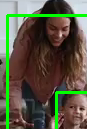

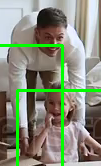

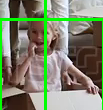

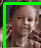

In [49]:
for count in range(number_of_items_to_track):
  cv2_imshow(first_frame[(int)(boxes[count][1]*a1/r1):(int)((boxes[count][3])*a1/r1),(int)(boxes[count][0]*a2/r2):(int)((boxes[count][2])*a2/r2)])


In [50]:
playVideo(filename="mouthwash_follower.mp4") 

In [52]:
playVideo(filename="/content/my_data/stock-footage-excited-happy-young-parents-run-push-cardboard-boxes-with-little-cute-children-daughters-ride.mp4", width=640, height=360)